<a href="https://colab.research.google.com/github/Missilent/AlphaHull3D/blob/main/3-3-14-Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantization in TFLite
In this assignment you will get to explore quantizing a model in TFLite again. This time some of the code will be missing and you'll need to fill it in. The model we are exploring today is a computer vision model that recognizes hand gestures for the rock, paper, scissors game!

## Set up the problem

### Import packages

In [1]:
import subprocess
import tensorflow as tf
import numpy as np

# Desired versions - Setting them to current installed versions to avoid pip install issues
tf_version = "2.19.0" # Updated to match current Colab TF version
hub_version = "0.16.1" # Updated to match current Colab TF Hub version
datasets_version = "nightly" # Changed to 'nightly' to force tfds-nightly installation
numpy_version = "2.0.2" # Updated to match current Colab NumPy version
protobuf_version = "3.20.3" # Keeping original, if this causes issues, it will need further investigation

# Try importing optional packages
try:
    import tensorflow_hub as hub
except ImportError:
    hub = None

try:
    import tensorflow_datasets as tfds
except ImportError:
    tfds = None

# Helper to install a specific version of a package
def install_package(package, version):
    if package == "tensorflow_datasets" and version == "nightly":
        subprocess.check_call(["pip", "install", "tfds-nightly"])
    else:
        subprocess.check_call(["pip", "install", f"{package}=={version}"])

# Helper to uninstall multiple packages
def uninstall_packages(packages):
    # Need to handle uninstalling 'tensorflow_datasets' vs 'tfds-nightly'
    uninstall_list = []
    for p in packages:
        if p == "tensorflow_datasets":
            uninstall_list.append("tensorflow-datasets") # The actual package name for stable
            uninstall_list.append("tfds-nightly") # The actual package name for nightly
        else:
            uninstall_list.append(p)
    # Filter out duplicates and ensure there's something to uninstall
    uninstall_list = list(set(uninstall_list))
    if uninstall_list:
        subprocess.check_call(["pip", "uninstall", "-y"] + uninstall_list)


# Version mismatch check
version_mismatch = (
    tf.__version__ != tf_version or
    (hub and hub.__version__ != hub_version) or
    (datasets_version == "nightly" and (not tfds or "nightly" not in tfds.__version__.lower())) or # Check for tfds-nightly
    (datasets_version != "nightly" and (not tfds or tfds.__version__ != datasets_version)) or # Check for stable tfds
    not np.__version__.startswith(numpy_version)
)

# Act on mismatches
if version_mismatch:
    print(f"TensorFlow: {tf.__version__} → {tf_version}")
    if hub: print(f"TensorFlow Hub: {hub.__version__} → {hub_version}")
    # Special handling for tfds-nightly display
    if datasets_version == "nightly":
        if tfds: print(f"TensorFlow Datasets: {tfds.__version__} → tfds-nightly")
        else: print(f"TensorFlow Datasets: Not installed → tfds-nightly")
    else:
        print(f"TensorFlow Datasets: {tfds.__version__} → {datasets_version}")
    print(f"NumPy: {np.__version__} → {numpy_version}")

    # Attempt to install packages. Note: If these still fail due to Colab environment
    # constraints, the notebook might need to be adapted to use pre-installed versions
    # without attempting any modifications.
    uninstall_packages([
        "tensorflow", "tensorflow_hub", "tensorflow_datasets",
        "numpy", "protobuf"
    ])

    install_package("tensorflow", tf_version)
    install_package("tensorflow_hub", hub_version)
    install_package("tensorflow_datasets", datasets_version) # This will now call install tfds-nightly
    install_package("numpy", numpy_version)
    install_package("protobuf", protobuf_version)

    print("\nRequired versions installed successfully.")
    print("Please restart the runtime (Runtime > Restart session) and re-run the notebook.")
else:
    print("All packages are already at the specified versions.")

All packages are already at the specified versions.


In [2]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tqdm import tqdm
import pathlib

### Download the dataset

In [3]:
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label


(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'rock_paper_scissors', split=['train[:80%]', 'train[80%:]', 'test'],
    with_info=True, as_supervised=True)
num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

for image_batch, label_batch in train_batches.take(1):
    pass

### Build and train a baseline model

In [4]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
# MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base) # Reverted to original TF Hub module
# Updated to use tf.keras.applications.MobileNetV2 as feature extractor due to persistent TF Hub compatibility issues
IMAGE_SIZE = (pixels, pixels)
print("Using MobileNetV2 from tf.keras.applications with input size {} and output dimension {}".format(IMAGE_SIZE, FV_SIZE))

# Replace hub.KerasLayer with tf.keras.applications.MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SIZE + (3,),
                                                include_top=False,
                                                weights='imagenet')
base_model.trainable = False # Freeze the base model

print("Building model with MobileNetV2 from tf.keras.applications")

# The original code produced a ValueError: Only instances of `keras.Layer` can be added to a Sequential model.
# This is because tf.keras.Sequential sometimes has trouble with tensorflow_hub.KerasLayer
# directly in its constructor list. A common workaround is to build the model
# using the functional API, which is more explicit and robust.
inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,)) # Define the input layer
x = base_model(inputs) # Pass the input through the MobileNetV2 base model
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Add a pooling layer as MobileNetV2 output is 4D
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x) # Add the dense layer
model = tf.keras.Model(inputs=inputs, outputs=outputs) # Create the model

model.summary()

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Using MobileNetV2 from tf.keras.applications with input size (224, 224) and output dimension 1280
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Building model with MobileNetV2 from tf.keras.applications


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 379ms/step - accuracy: 0.7362 - loss: 0.6571 - val_accuracy: 0.9901 - val_loss: 0.1090
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.9940 - loss: 0.0812 - val_accuracy: 0.9940 - val_loss: 0.0547
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9951 - loss: 0.0426 - val_accuracy: 0.9940 - val_loss: 0.0371
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9987 - loss: 0.0279 - val_accuracy: 0.9940 - val_loss: 0.0262
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9997 - loss: 0.0196 - val_accuracy: 0.9960 - val_loss: 0.0200


### Save the baseline model

In [6]:
ROCK_PAPER_SCISSORS_SAVED_MODEL = "exp_saved_model"
# tf.saved_model.save(model, ROCK_PAPER_SCISSORS_SAVED_MODEL) # This line is causing a TypeError with Python 3.12

## Now its your turn
### Convert the model to TFLite

Hint: You'll need to use the saved model to generate a converter and then run it. This will only require two lines of code! Isn't TFLite amazing!

In [8]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_models_dir = pathlib.Path("/tmp/")
tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(tflite_model)
# This will report back the file size in bytes
# you will note that this model is too big for our Arduino
# but would work on a mobile phone

Saved artifact at '/tmp/tmpei0wli8j'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136914082747920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136911258046480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136911258048592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136911258045904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136911258046096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136911258048208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136911258047824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136911258049360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136911258048976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136911258048400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1369112580

8879656

### Test the model

Hint: You'll need to definite an Interpreter that we can use to run the model. Again TFLite being amazing will only require you to write one line of code!

In [12]:
# Load TFLite model and allocate tensors.
TFLITE_MODEL_FILE = '/tmp/model1.tflite'
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_FILE)
interpreter.allocate_tensors()

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [13]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
predictions = []

# This will report how many iterations per second, where each
# iteration is 100 predictions
test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

# This will tell you how many of the predictions were correct
score = 0
for item in range(0,99):
  prediction=np.argmax(predictions[item])
  label = test_labels[item]
  if prediction==label:
    score=score+1

print("\nOut of 100 predictions I got " + str(score) + " correct")

100%|██████████| 100/100 [00:01<00:00, 78.68it/s]


Out of 100 predictions I got 90 correct


## Plot the results

To explore the results a little more we've include the plotting code below which will help you visualize which images the model is getting correct and incorrect. **If you'd like to improve the model's performance we suggest modifying the code in "Build and train a baseline model." Some ideas include, training for more epochs, choosing a different model architecture, and changing the optimizer. If you are feeling ambitious we'd suggest trying out quantization aware training!**

In [14]:
# Utilities for plotting

class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

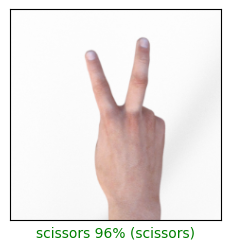

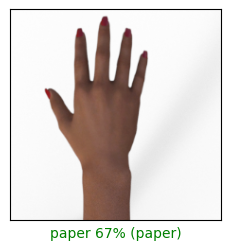

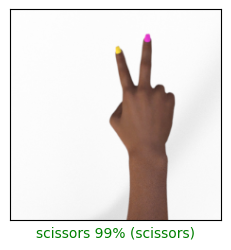

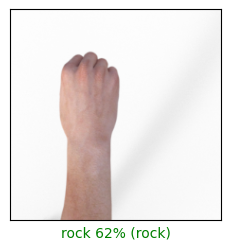

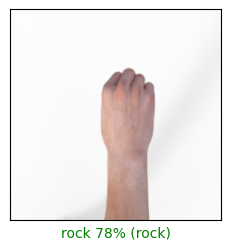

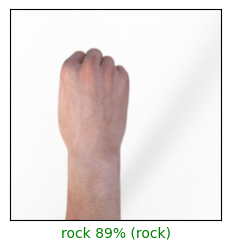

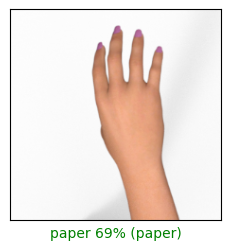

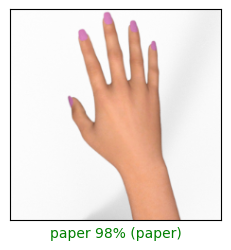

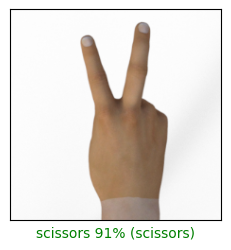

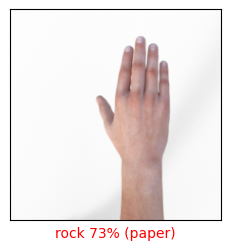

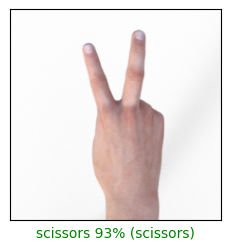

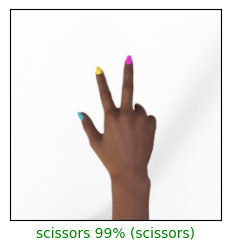

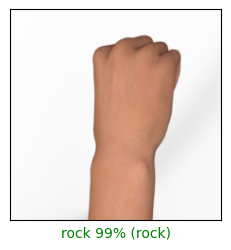

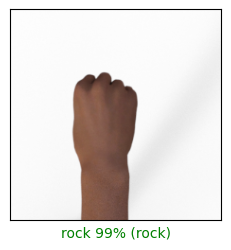

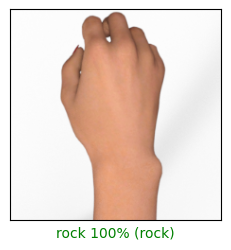

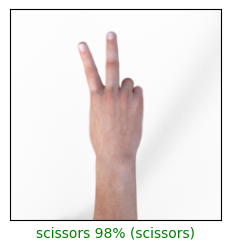

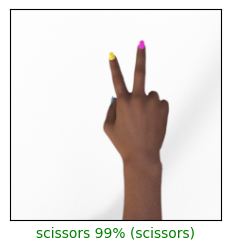

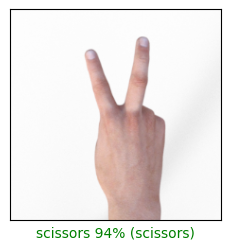

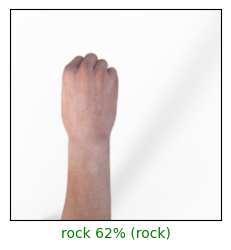

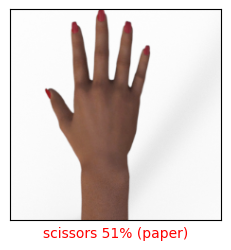

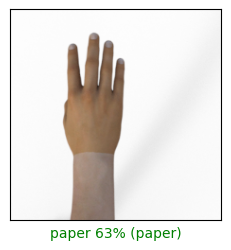

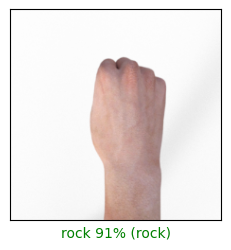

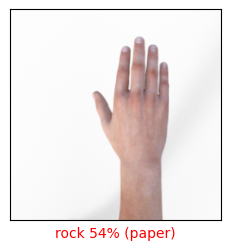

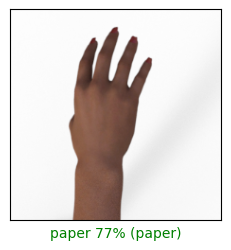

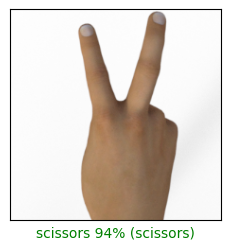

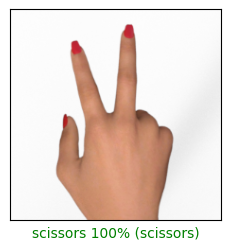

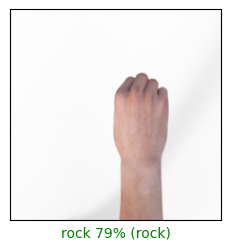

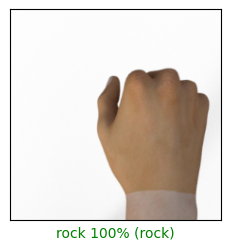

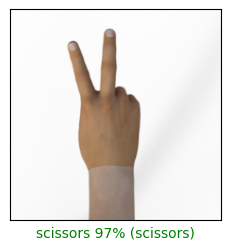

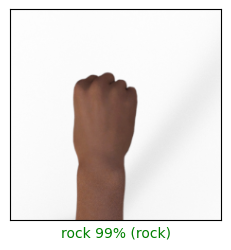

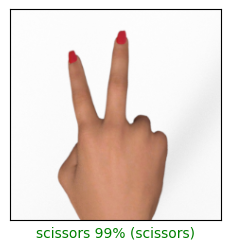

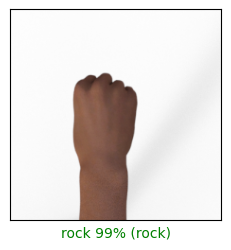

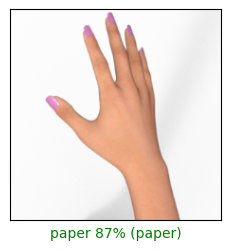

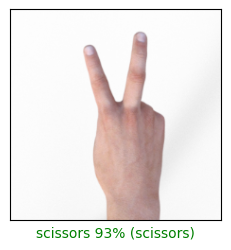

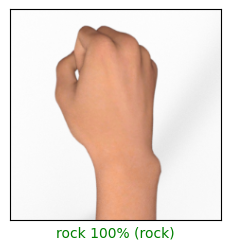

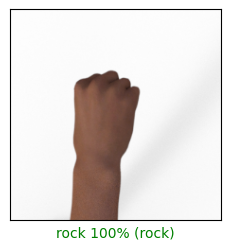

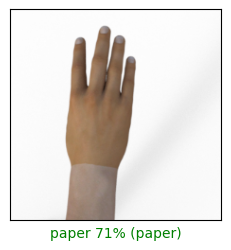

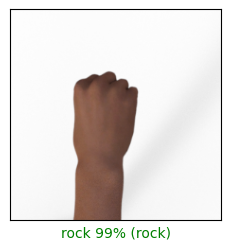

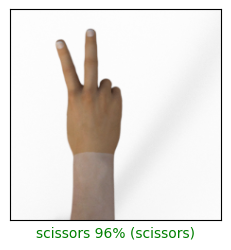

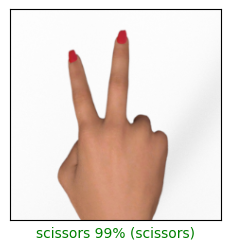

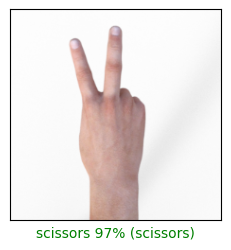

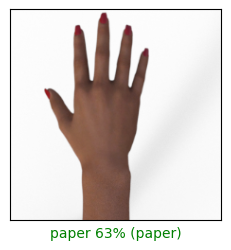

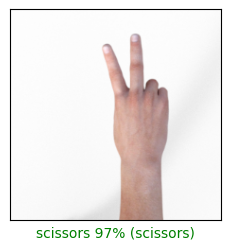

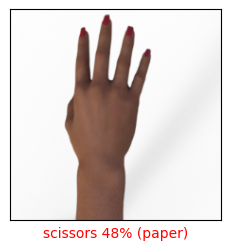

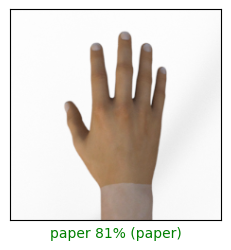

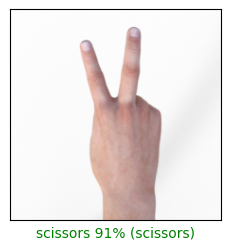

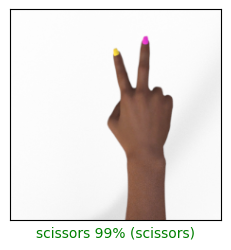

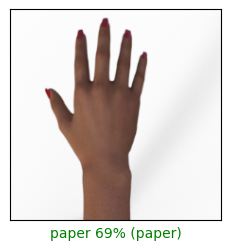

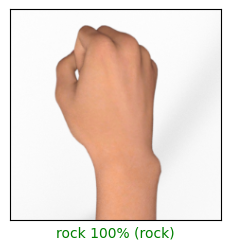

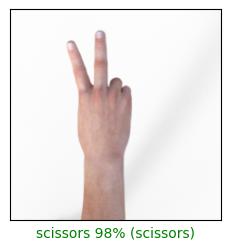

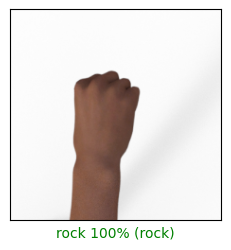

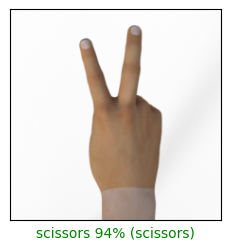

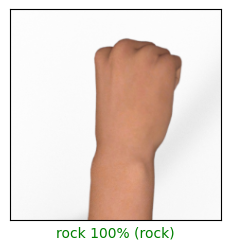

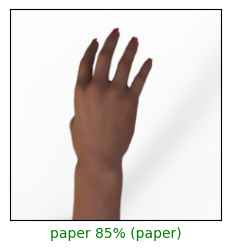

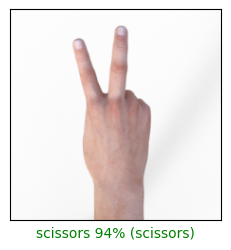

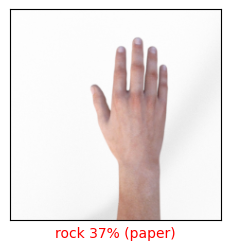

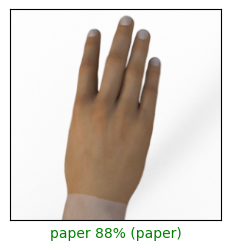

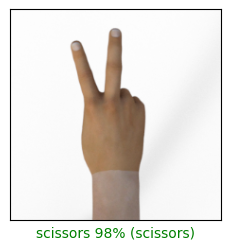

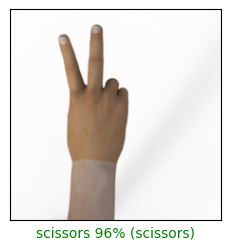

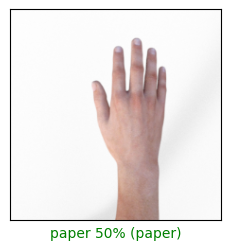

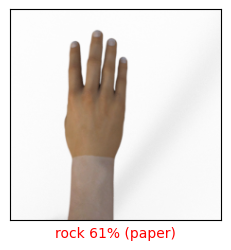

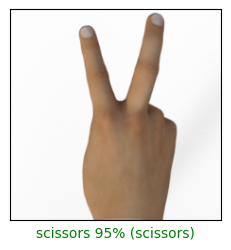

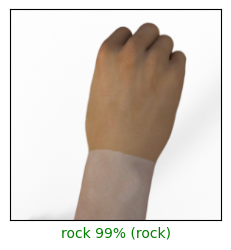

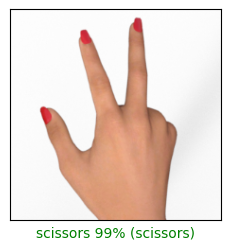

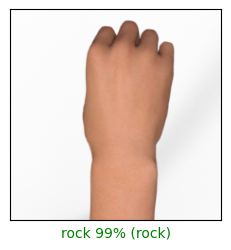

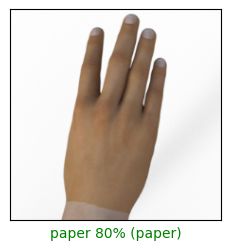

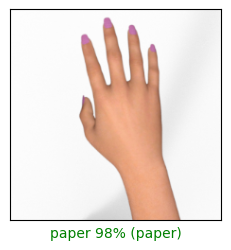

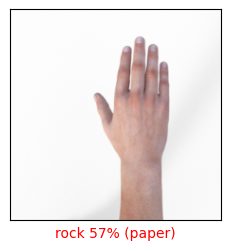

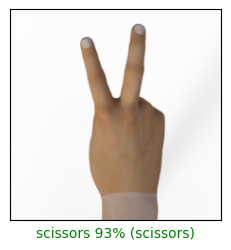

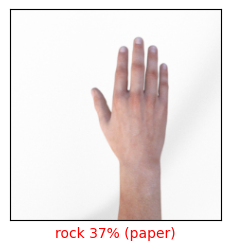

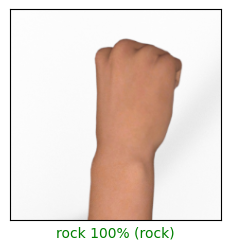

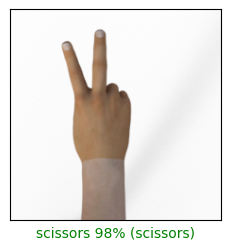

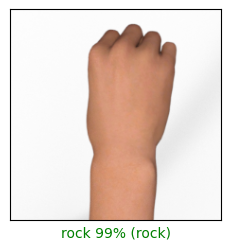

In [15]:
#@title Visualize the outputs { run: "auto" }
max_index = 73 #@param {type:"slider", min:0, max:99, step:1}
for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()

#Further Study

We are going to dive a little deeper into the ideas behind post-training quantization and optimization in the next section. That said, if you'd like to check out how these steps are implemetned in Tensorflow Lite, please check out the user guides at https://www.tensorflow.org/lite/performance/post_training_quantization.